In [ ]:
# LDA : Thanks to machinelearningplus.com for their educational guide on LDA 
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
!pip install pyLDAvis # install then restart runtime 

In [ ]:
!pip install -U spacy 

In [ ]:
!pip install --upgrade gensim==3.8

In [ ]:
#install Mallet
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
#to be run only once 
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
## Main libraries 
import pandas as pd
import numpy as np

# Preprocessing
import gensim
from gensim.utils import simple_preprocess 
from gensim.parsing.preprocessing import STOPWORDS
import re
from gensim.models.phrases import Phrases, Phraser
from gensim.models.wrappers import LdaMallet

# to upload local files to Google cloud #incase used 
from google.colab import files

# Lemmatization
import spacy
from spacy import displacy

import gensim.corpora as corpora

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis 
#import pyLDAvis.gensim as gensimvis # with older versions of pyLDAvis

import matplotlib.pyplot as plt
%matplotlib inline



Load extracted submissions and comments 

In [ ]:
# use this as many Comments files you have, just change the dataframe number and file name 
cdf= pd.read_csv('/content/drive/MyDrive/TMData/comments_ve2y.csv', on_bad_lines='skip') 
cdf1= pd.read_csv('/content/drive/MyDrive/TMData/comments_ca1y.csv', on_bad_lines='skip') 

In [ ]:
cdf_ve = cdf[cdf['created_utc']> 1606780799].copy() # selecting comments after 1/12/2020 [as I have some older data in my file]
print(cdf_ve.shape)

(511071, 9)


In [ ]:
# Combine all Comments dataframes in one dataframe 
cdf_master = cdf_ve.append([cdf1], ignore_index= True)  #ignore_index= True

In [ ]:
# use this as many Submissions files you have, just change the dataframe number and file name 
sdf= pd.read_csv('/content/drive/MyDrive/TMData/submissions_ve1y.csv', on_bad_lines='skip'); 
sdf1= pd.read_csv('/content/drive/MyDrive/TMData/submissions_ca1y.csv', on_bad_lines='skip'); 

In [ ]:
# Combine all Submissions dataframes in one dataframe 
sdf_master = sdf.append([sdf1], ignore_index = True)  

In [ ]:
#check number of submissions and comments 
print('Total number of submissions' + " " + str(len(sdf_master)))
print('Total number of comments' + " " + str(len(cdf_master)))

Total number of submissions 21030
Total number of comments 514002


Deal with removed/deleted submissions and comments 

In [ ]:
#noticed that some "removed" submissions have some text beside the word "removed", so this code is to process that.
sdf_master['selftext'] = sdf_master['selftext'].replace(r"\[removed\].*", value='[removed]', regex=True).copy()

In [ ]:
#Count the number of deleted or removed submissions/comments from the corpus 
print(len(sdf_master[(sdf_master['selftext'] == '[removed]') | (sdf_master['selftext'] == '[deleted]')] ))
print(len(cdf_master[(cdf_master['body'] == '[removed]') | (cdf_master['body'] == '[deleted]')] ))

1563
10675


In [ ]:
#Count the number of deleted or removed submissions which has no comments from the corpus 
print(len((sdf_master[(((sdf_master['selftext'] == '[removed]') | (sdf_master['selftext'] == '[deleted]')) & (sdf_master['num_comments'] == 0))== True])))

#Count the number of deleted or removed comments from the corpus 
print(len(cdf_master[(cdf_master['body'] == '[removed]') | (cdf_master['body'] == '[deleted]')] ))

768
10675


In [ ]:
# Remove deleted and removed comments/submissions
sdf_master_clean = sdf_master.loc[(((sdf_master['selftext'] == '[removed]') | (sdf_master['selftext'] == '[deleted]')) & (sdf_master['num_comments'] == 0))== False].copy()
print('Total number of submissions = ', len(sdf_master_clean))

cdf_master_clean = cdf_master.loc[(cdf_master['body'] != '[removed]') & (cdf_master['body'] != '[deleted]')].copy()
print('Total number of comments = ', len(cdf_master_clean))
#for .copy, check https://www.dataquest.io/blog/settingwithcopywarning/ (I used .loc, but it wasn't enough , .copy solved the issue, it seems it is hidden chain)


Total number of submissions =  20262
Total number of comments =  503327


Create documents:  each submission and its comments are considered as one document 

In [ ]:
#Just add a space before a comment's body to enhnce readability in next steps 
cdf_master_clean['body'] =  ' ' + cdf_master_clean['body'] 

In [ ]:
#Group comments related to the same submission
cdf_Grouped = cdf_master_clean.groupby('submission_id', as_index=False)['body'].sum()

In [ ]:
#check the total no. of unique submissions, and shape of the grouped comments dataframe 
cdf_Grouped.shape

(17186, 2)

In [ ]:
#check the total no. of submissions in the submissions dataframe 
# number of submission could be higher due to submissions which have no comments 
sdf_master_clean.shape

(20262, 9)

In [ ]:

#Combine submissions with their comments to create documents
final_df = sdf_master_clean.merge(cdf_Grouped,  how= 'left',left_on='id', right_on='submission_id')

In [ ]:
#Check shape and number of documents in the final dataframe 
final_df.shape

(20262, 11)

In [ ]:
#Combine the text of submission and its comments in a single field for future text processing 
# Note that both submission's title and text are considered becuase there are a lot of submissions having titles without text.
final_df['posts_texts'] = final_df["title"].astype(str) + ' ' + final_df["selftext"].astype(str) + ' ' + final_df["body"].astype(str)

In [ ]:
# Seperate the text for documents
posts_texts= final_df['posts_texts'].copy()

Documents Preprocessing 

In [ ]:
#'nan' and newline charachter removal 
posts_texts = posts_texts.replace(r'\\n',' ', regex=True) # several newlines charachers were noticed after data extraction 
posts_texts = posts_texts.replace(r'\b([Nn][Aa][Nn])\b',' ', regex=True) # 'nan' happended because of combining title of submission and its empty text
posts_texts = posts_texts.replace(r'([Hh][Aa]){2,}',' ', regex=True) #  remove hahaha related words
posts_texts = posts_texts.replace(r'([lL][Oo][lL]){2,}',' ', regex=True) # remove lollol related words
posts_texts = posts_texts.replace(r'(ID4|ID.4)','VWIDIV', regex=True) # to handle Volkswagen ID.4 issue
posts_texts = posts_texts.replace(r'(ID3|ID.3)','VWIDIII', regex=True) # to handle Volkswagen ID.3 issue
posts_texts = posts_texts.replace(r'(ID2|ID.2)','VWIDII', regex=True) # to handle Volkswagen ID.2 issue
posts_texts = posts_texts.replace(r'(ID6|ID.6)','VWIDVI', regex=True) # to handle Volkswagen ID.6 issue

In [ ]:
#check if we have empty documents 
len(posts_texts[posts_texts == '']) # answer should be 0 if no empty documents
#posts_texts[0:22]

0

In [ ]:
#removing links 
removed_links = posts_texts.replace(r"[\[]?[hH][tT][tT][Pp]\S+", value='', regex=True).copy()# ("[([hH]ttp\S+", "")
#note: added [] to the regex, because there was some cells with only the URL put inside [], so removing the http only will lead to having a cell with [], and then empty one after preprocessing 


In [ ]:
# Reseting index
removed_links.reset_index(drop= True, inplace=True)

In [ ]:
#Preparing stopwords based on Gensim set "STOPWORDS"
my_stop_words = STOPWORDS.union(set(['jpg', 'png', 'yes','isn','aren', 'removed','deleted','www','http', 'https', 'shit', 'lol', 'fuck', 'ev', 've', 'couldn', 'wouldn', 'vehicle', 'car','cars','vehicles' ])) 
my_stop_words = my_stop_words.difference(set(['system','computer','bill','re'])) 
print(my_stop_words)


frozenset({'side', 'across', 'every', 'throughout', 'what', 'aren', 'many', 'much', 'you', 'ltd', 'amoungst', 'once', 'everything', 'were', 'anyway', 'whereupon', 'towards', 'see', 'became', 'anyone', 'be', 'otherwise', 'would', 'five', 'six', 'moreover', 'neither', 'often', 'serious', 'when', 'which', 'next', 'part', 'his', 'wouldn', 'her', 'where', 'could', 'whither', 'twelve', 'each', 'put', 'at', 'really', 'jpg', 'may', 'the', 've', 'whatever', 'con', 'until', 'sixty', 'hereafter', 'shit', 'while', 'herein', 'thru', 'with', 'us', 'also', 'around', 'enough', 'inc', 'make', 'more', 'say', 'become', 'about', 'show', 'due', 'along', 'thereby', 'un', 'it', 'a', 'quite', 'eleven', 'doing', 'hundred', 'rather', 'during', 'formerly', 'sometime', 'various', 'afterwards', 'out', 'one', 'so', 'now', 'former', 'couldnt', 'together', 'cry', 'fifty', 'my', 'whom', 'nowhere', 'these', 'although', 'http', 'hence', 'please', 'ie', 'nor', 'https', 'perhaps', 'between', 'does', 'therefore', 'already'

In [ ]:
#lower case, tokenize posts including removing punctuations, remove very short words(len=1) and change non-english characters to english ones.
# and remove Stop Words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc).encode('utf-8'), deacc=True) if word not in my_stop_words] for doc in texts]

data_words_nostops = remove_stopwords(removed_links)

In [ ]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#!python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
def lemmatization(texts, allowed_postags=['NOUN','VERB']): #['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) # I understand this is to convert sent from list to str, because nlp takes string
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        #only allowed post tags are kept and enter lemma
    return texts_out

In [ ]:
# Do lemmatization keeping only noun, vb
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN','VERB']) #['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

In [ ]:
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[-1:])
#type(corpus)

[[(261, 1), (445, 1), (3161, 1), (5934, 1)]]


In [ ]:
print('Number of unique tokens: %d' % len(id2word)) #Dictionary
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 47877
Number of documents: 20262


In [ ]:
#Set the path to the Mallet binary
import os
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this

In [ ]:
import logging
logging.basicConfig(filename='gensim.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.INFO)

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=39, id2word=id2word, optimize_interval=10, iterations= 2000, random_seed=42 )
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=25, id2word=id2word, random_seed=42, optimize_interval=10)

In [ ]:
from pprint import pprint #pretty print

In [ ]:
#Coherence c_v

#pprint(ldamallet.show_topics(formatted=False))

from gensim.models.coherencemodel import CoherenceModel

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.47429437796772295


In [ ]:
Topics= ldamallet.show_topics(num_topics=39, num_words=20)       # (formatted=False)
#print(T)
#pprint(ldamallet.show_topics(formatted=False))

In [ ]:
import csv
with open('TopicsGrouped39_2000it_All_Corr.csv','w') as f:
     write = csv.writer(f)
     write.writerows(Topics)

In [ ]:
6#Convert the Mallet model to Gensim format.
gensimmodelMall = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet) #ldamallet 
#https://github.com/polsci/colab-gensim-mallet/blob/master/topic-modeling-with-colab-gensim-mallet.ipynb

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(gensimmodelMall, corpus, id2word, sort_topics=False) #https://github.com/bmabey/pyLDAvis/issues/127
vis

In [ ]:
pyLDAvis.save_html(vis, 'lda42N.html')

In [ ]:
all_topics = gensimmodelMall.get_document_topics(corpus, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)

#https://stackoverflow.com/questions/46574720/python-gensim-lda-add-the-topic-to-the-document-after-getting-the-topics/61397756#61397756
#https://radimrehurek.com/gensim/matutils.html#gensim.matutils.corpus2csc

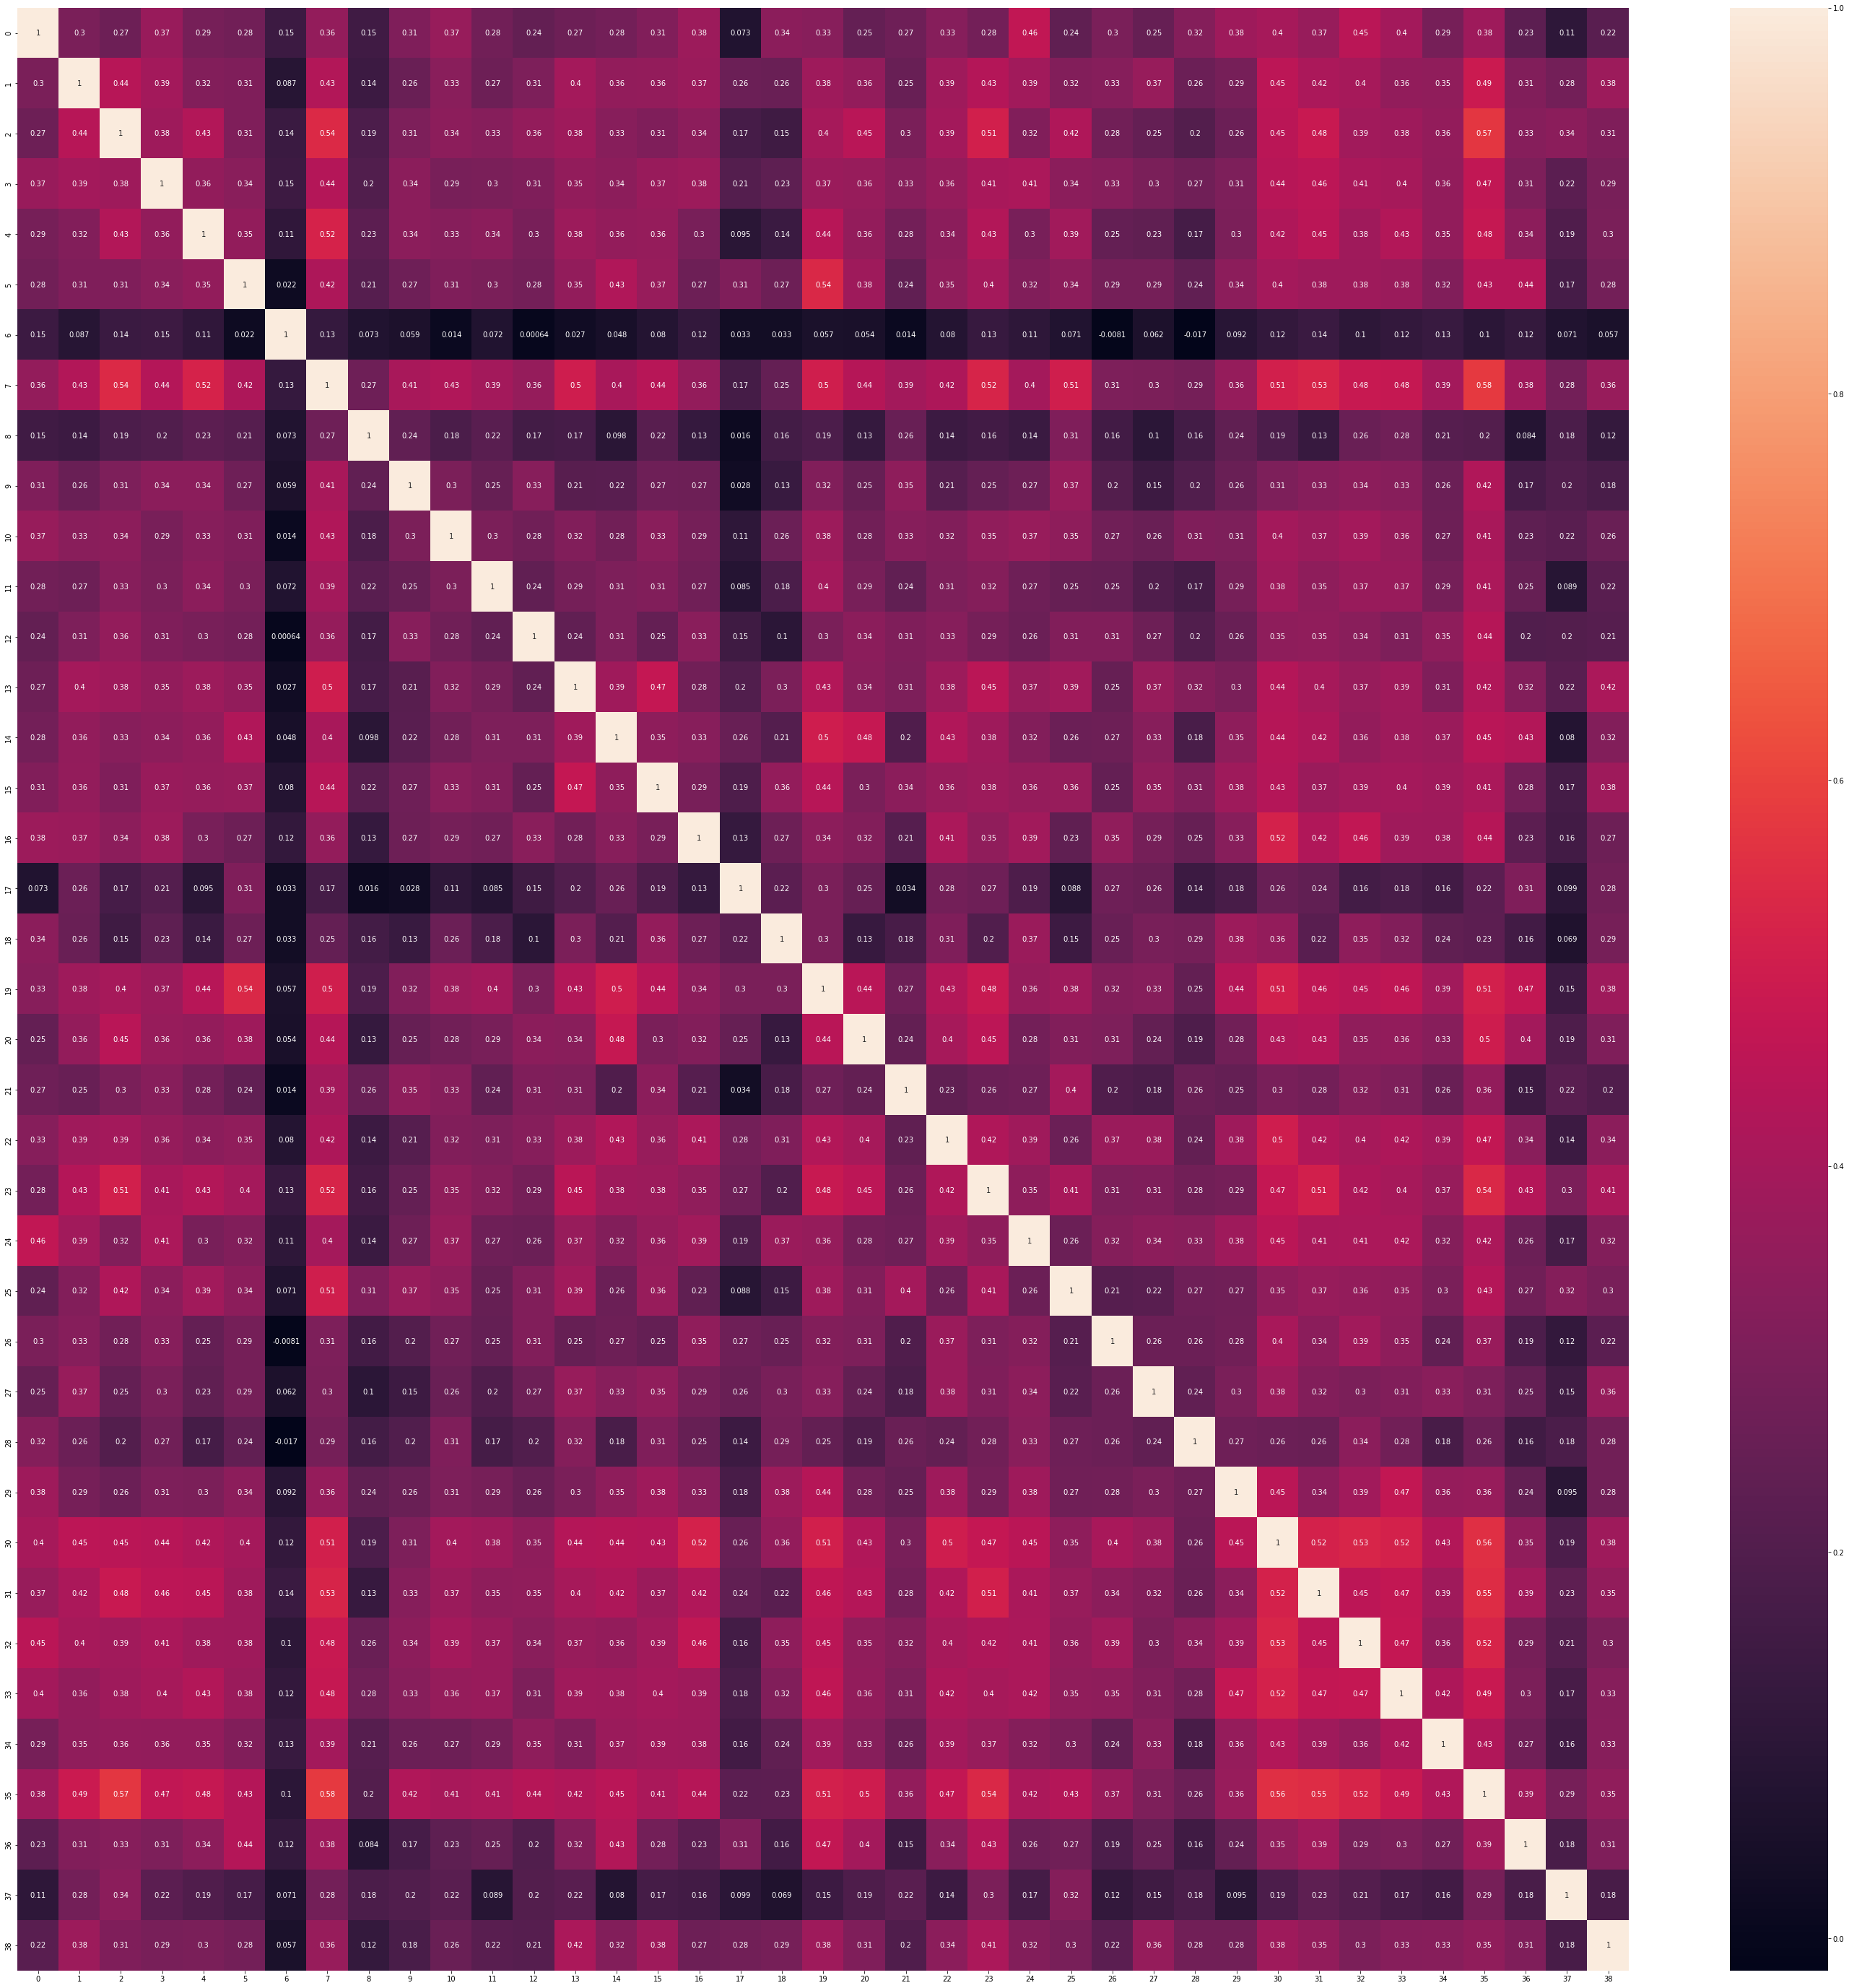

In [ ]:
import seaborn as sns
plt.figure(figsize=(50,50))
svm = sns.heatmap(all_topics_df.corr(method= 'spearman'), annot=True)
figure = svm.get_figure()    
figure.savefig('svm_heatmapgrpspear.png', dpi=400)